# European Restaurant Reviews

# Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer

from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.preprocessing import OneHotEncoder, LabelEncoder


# Functions

In [12]:

def check_class_imbalance(target):
  unique, counts = np.unique(target, return_counts=True)
  plt.figure(figsize=(10, 7))
  plt.pie(counts, labels=unique, startangle=140, autopct="%1.1f%%")
  plt.legend()
  plt.show()
  
  plt.figure(figsize=(10, 7))
  sns.countplot(x=target)
  plt.xlabel("Target Class Breakdown")
  plt.ylabel("Counts")
  plt.xticks(rotation=45)
  plt.show()

def check_nulls_dupes(df):
  print(f"The Amount of Nulls: {df.isna().sum()}")
  print(f"The Amount of Dupes: {df.duplicated().sum()}")

def aggregate_dataset(df, interested_columns, agg_col, function):
  
  plt.figure(figsize=(16, 16))
  rows = len(interested_columns)
  dims = (rows + 3 )//4
  
  for idx, col in enumerate(interested_columns):
    grouped_df = getattr(df.groupby(agg_col)[col], function)().reset_index(name=col)
    plt.subplot(dims, 4, idx+1)
    sns.barplot(data=grouped_df, x=agg_col, y=col)
    plt.title(f"Agg of {col}")
    plt.ylabel(col)
    plt.xticks(rotation =45)
  
  plt.tight_layout()
  plt.show()

# EDA Analysis

In [3]:
df = pd.read_csv("/Users/maukanmir/Downloads/data.csv")
df

,Country,Restaurant Name,Sentiment,Review Title,Review Date,Review
0,France,The Frog at Bercy Village,Negative,Rude manager,May 2024 •,The manager became agressive when I said the c...
1,France,The Frog at Bercy Village,Negative,A big disappointment,Feb 2024 •,"I ordered a beef fillet ask to be done medium,..."
2,France,The Frog at Bercy Village,Negative,Pretty Place with Bland Food,Nov 2023 •,"This is an attractive venue with welcoming, al..."
3,France,The Frog at Bercy Village,Negative,Great service and wine but inedible food,Mar 2023 •,Sadly I used the high TripAdvisor rating too ...
4,France,The Frog at Bercy Village,Negative,Avoid- Worst meal in Rome - possibly ever,Nov 2022 •,From the start this meal was bad- especially g...
...,...,...,...,...,...,...
1497,Cuba,Old Square (Plaza Vieja),Negative,The Tourism Trap,Oct 2016 •,Despite the other reviews saying that this is ...
1498,Cuba,Old Square (Plaza Vieja),Negative,the beer factory,Oct 2016 •,beer is good. food is awfull The only decent...
1499,Cuba,Old Square (Plaza Vieja),Negative,brewery,Oct 2016 •,"for terrible service of a truly comedic level,..."
1500,Cuba,Old Square (Plaza Vieja),Negative,It's nothing exciting over there,Oct 2016 •,We visited the Havana's Club Museum which is l...


# Check For Nulls and Dupes

In [4]:
check_nulls_dupes(df)

The Amount of Nulls: Country            0
Restaurant Name    0
Sentiment          0
Review Title       0
Review Date        0
Review             0
dtype: int64
The Amount of Dupes: 49


In [5]:
df.drop_duplicates(inplace=True)

# Check For Class Imbalance

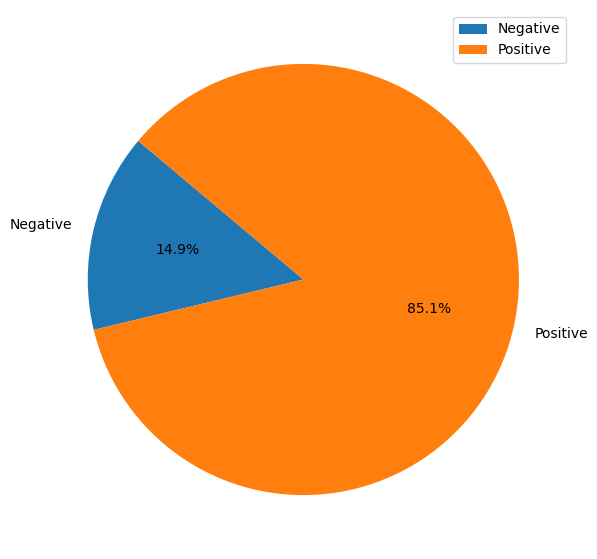

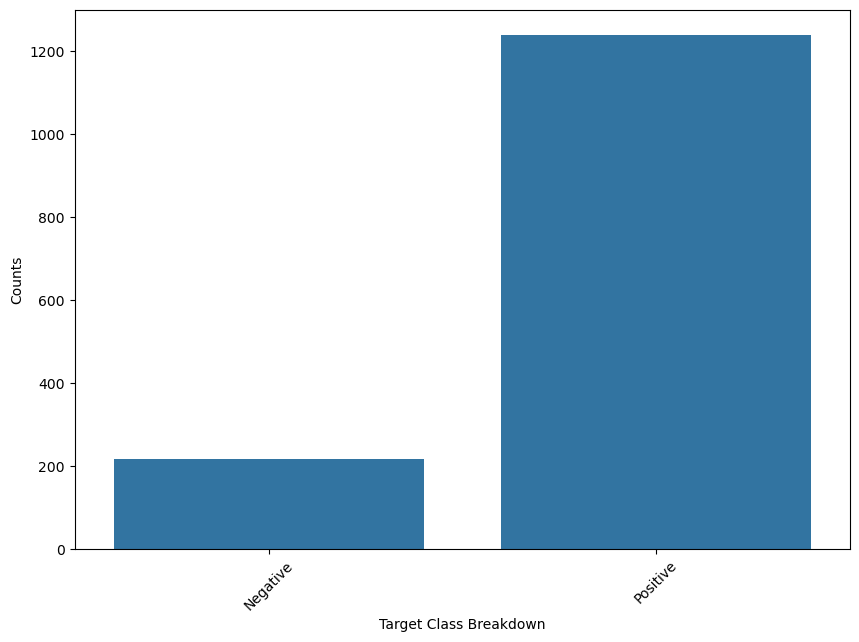

In [6]:
check_class_imbalance(df["Sentiment"])

# Severe Class Imbalance Exists

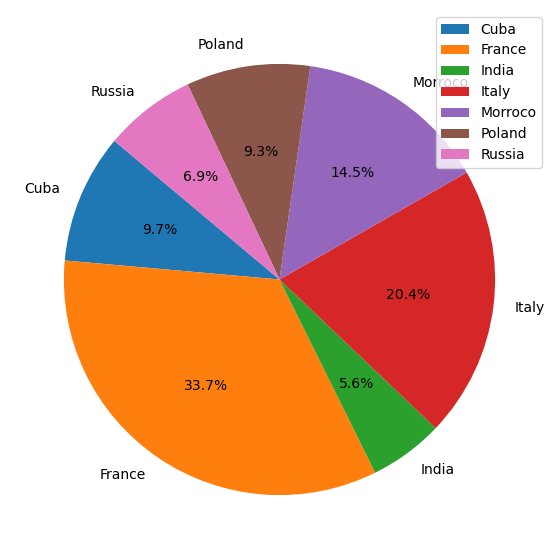

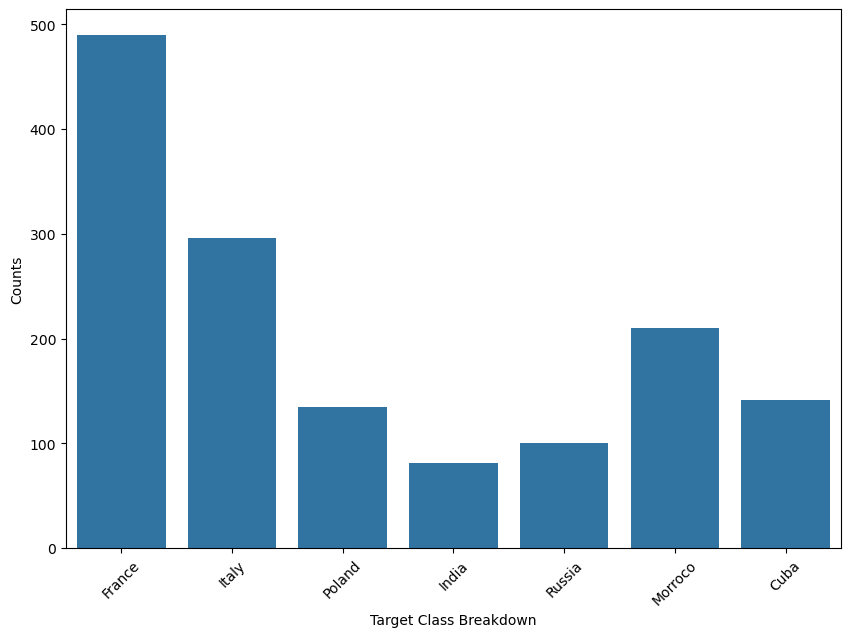

In [7]:
check_class_imbalance(df["Country"])

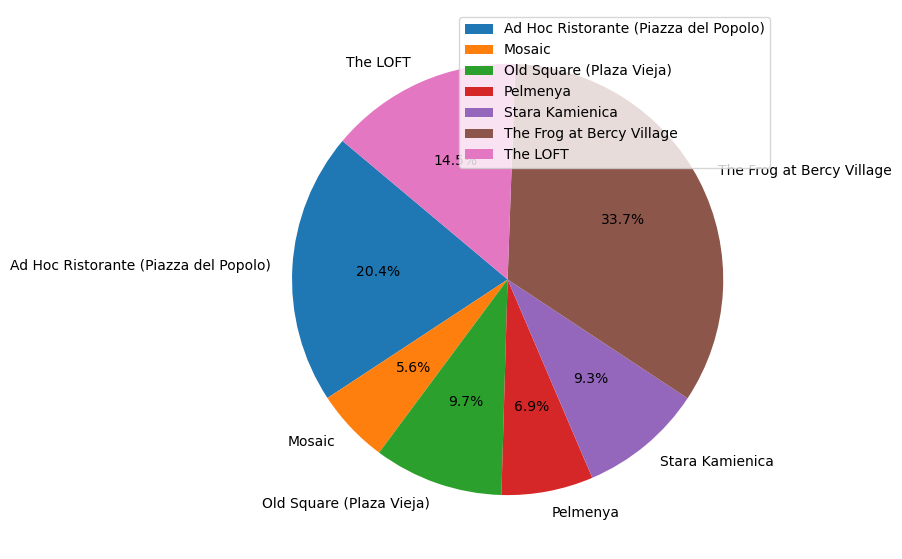

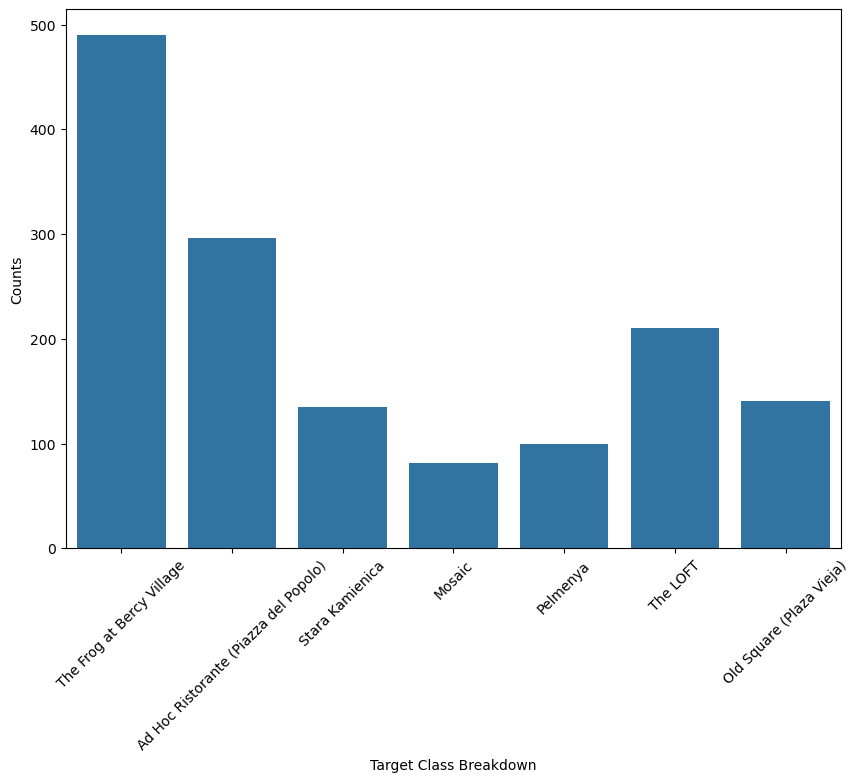

In [8]:
check_class_imbalance(df["Restaurant Name"])

# Positive Sentiment DF Analysis

In [10]:
positive_sentiment = df[df["Sentiment"] == "Positive"]

In [11]:
df

,Country,Restaurant Name,Sentiment,Review Title,Review Date,Review
0,France,The Frog at Bercy Village,Negative,Rude manager,May 2024 •,The manager became agressive when I said the c...
1,France,The Frog at Bercy Village,Negative,A big disappointment,Feb 2024 •,"I ordered a beef fillet ask to be done medium,..."
2,France,The Frog at Bercy Village,Negative,Pretty Place with Bland Food,Nov 2023 •,"This is an attractive venue with welcoming, al..."
3,France,The Frog at Bercy Village,Negative,Great service and wine but inedible food,Mar 2023 •,Sadly I used the high TripAdvisor rating too ...
4,France,The Frog at Bercy Village,Negative,Avoid- Worst meal in Rome - possibly ever,Nov 2022 •,From the start this meal was bad- especially g...
...,...,...,...,...,...,...
1492,Cuba,Old Square (Plaza Vieja),Negative,It's nothing exciting over there,Oct 2016 •,We visited the Havana's Club Museum which is l...
1493,Cuba,Old Square (Plaza Vieja),Negative,Tourist Trap,Oct 2016 •,Food and service was awful. Very pretty stop. ...
1494,Cuba,Old Square (Plaza Vieja),Negative,"Over-renovated, or in a state of transition?",Oct 2016 •,"I was disappointed with the Plaza Vieja, to wh..."
1495,Cuba,Old Square (Plaza Vieja),Negative,"The square is beautiful, but that's it.",Oct 2016 •,Beautiful in the square and up to two blocks o...
